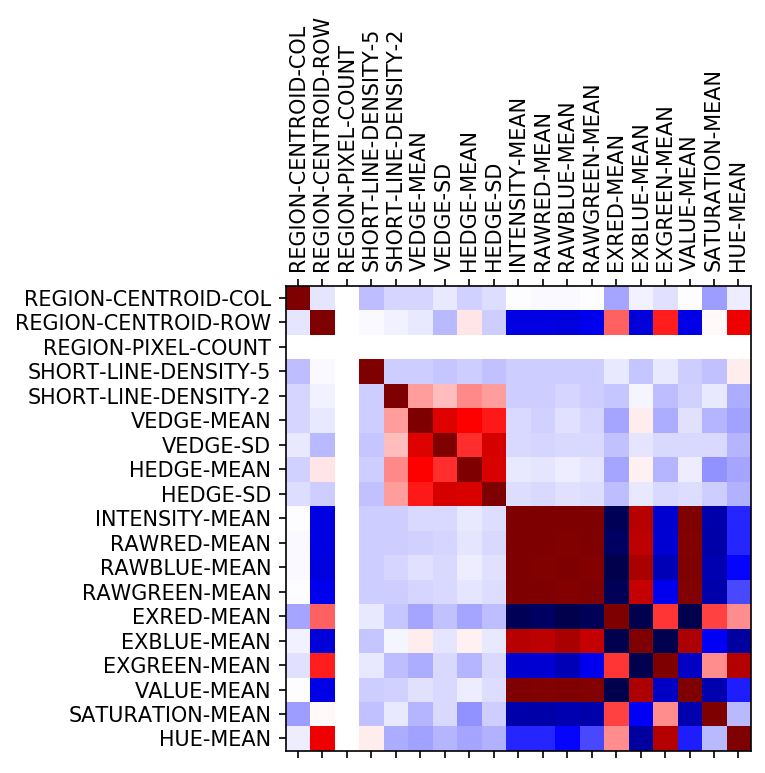

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from metrics import huber, l2_log

%matplotlib inline

df = pd.read_csv('data/data.csv')

X_cols = [c for c in df.keys()][1:]

plt.figure(dpi=150)
plt.matshow(df[X_cols].corr(), cmap='seismic',  fignum=1)

ticks = [i for i in range(0, len(X_cols))]

plt.xticks(ticks, X_cols, rotation='vertical')
plt.yticks(ticks, X_cols)

plt.show()

# Remove useless features
JUNK_FEATURES = ['REGION-PIXEL-COUNT', # STD = 0
                 ]

for f in JUNK_FEATURES:
    X_cols.remove(f)

X = df[X_cols].values
y = df['CLASS'].values

kf = KFold(n_splits=10, random_state=0, shuffle=True)
kf.get_n_splits(X)

def plot_knn(weights: list, metrics: list, title: str = 'K-Nearest Neighbors', max_k: int=10, z_score: bool = True, pca: bool = False, pca_dims: int = 10):

    color_map = {
        'l1': 'b',
        'l2': 'r',
        'cosine': 'g',
        'chebyshev': 'y',
        'huber': 'm',
        'l2_log': 'c'
    }
    
    marker_map = {
        'uniform': 'o--',
        'distance': 'o-'
    }
    
    legend = []
    
    plt.figure(dpi=150)
    
    for weight in weights:
    
        
        for metric in metrics:
                    
            px = [x for x in range(1, max_k+1)]
            py = np.zeros((len(px),))
                
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index].copy(), X[test_index].copy()
                y_train, y_test = y[train_index].copy(), y[test_index].copy()
                
                if z_score:
                                    
                    u = np.mean(X_train, axis=0)
                    o = np.std(X_train, axis=0)
                    
                    X_train -= u
                    X_train /= o
                    
                    X_test -= u
                    X_test /= o
                    
                if pca:
                    pca = PCA(n_components=pca_dims)
                    pca.fit(X_train)
                    X_train = pca.transform(X_train)
                    X_test = pca.transform(X_test)
                
                for k in range(1, max_k+1):
                    neigh = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weight)
                    neigh.fit(X_train, y_train)
                    score = neigh.score(X_test, y_test)
                    
                    py[k-1] += score
                    
            py = 100*py / 10 
                    
            if type(metric) != str:
                metric_key = metric.__name__
            else:
                metric_key = metric
                    
            plt.plot(px, py, '%s%s' % (color_map[metric_key], marker_map[weight]))
            legend.append("%s (%s)" % (metric_key, weight))
    
            for i in range(0, len(px)):
                plt.annotate("%.1f" % py[i], [px[i], py[i]])
    
    plt.grid()
    plt.ylabel('%d-Folds Validation Accuracy' % max_k)
    plt.xlabel('k')
    plt.xticks(px)
    if type(title) == str:
        plt.title(title)
    else:
        plt.title(title.__name__)
    plt.legend(legend)
    plt.show()

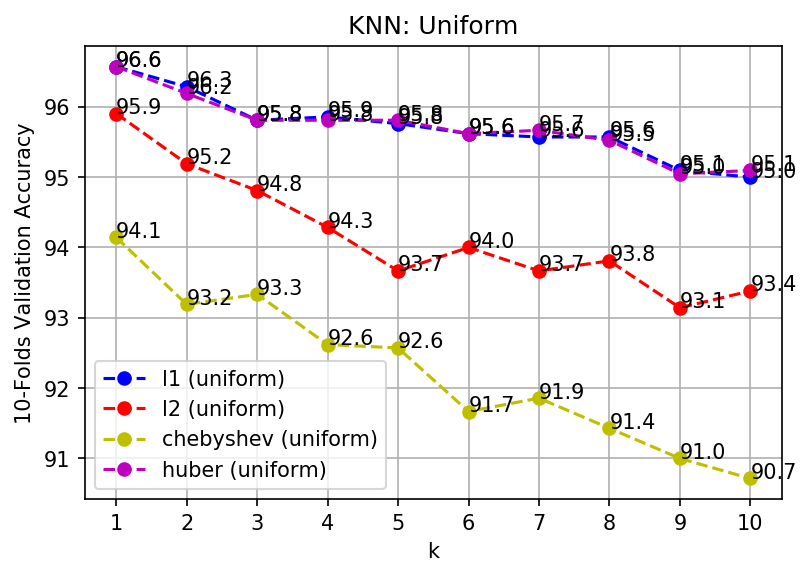

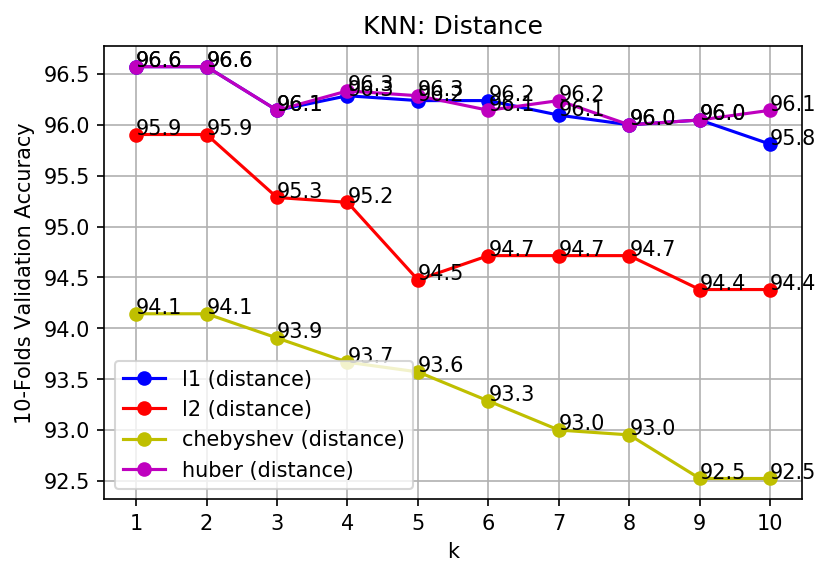

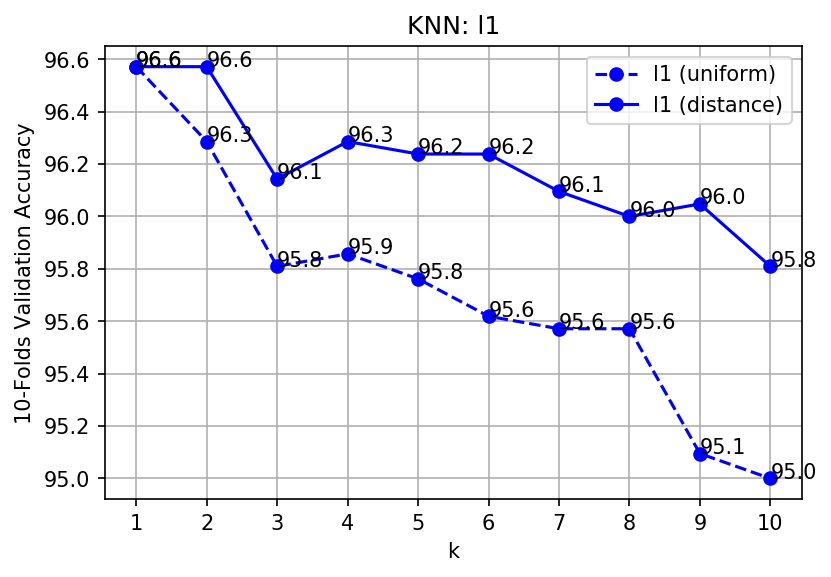

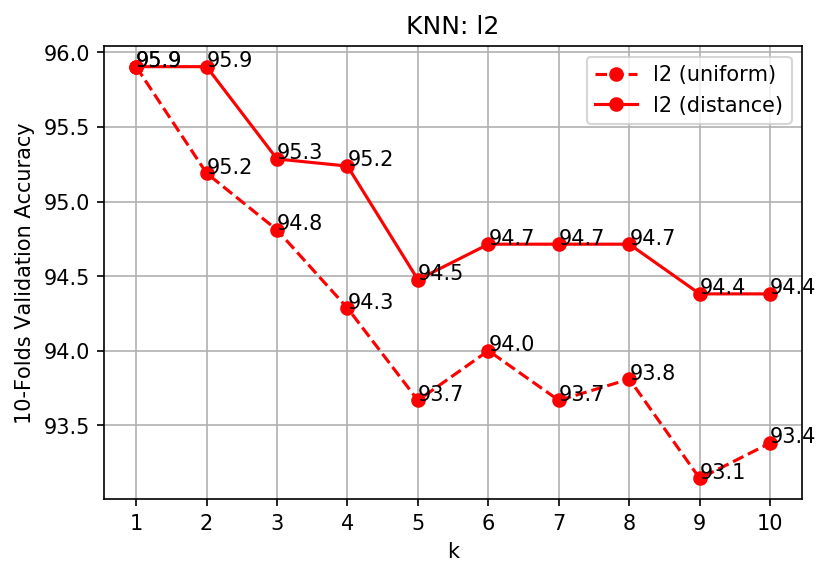

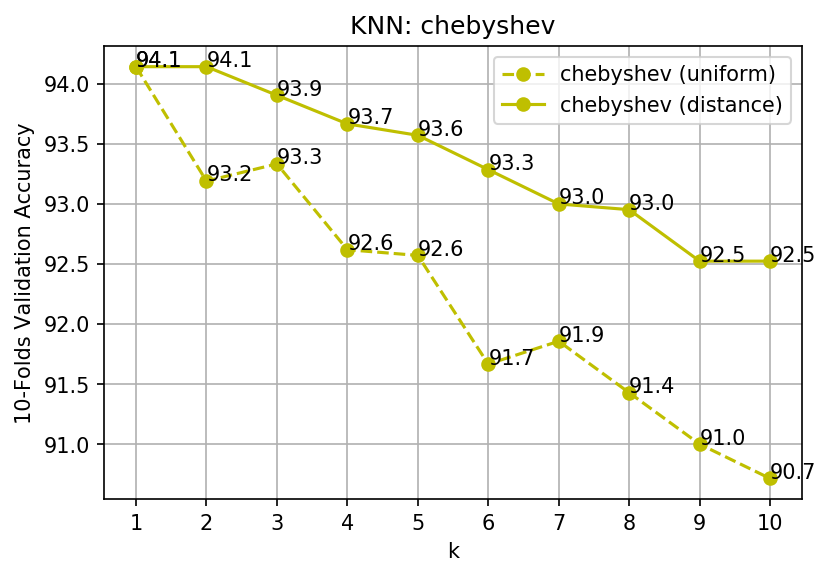

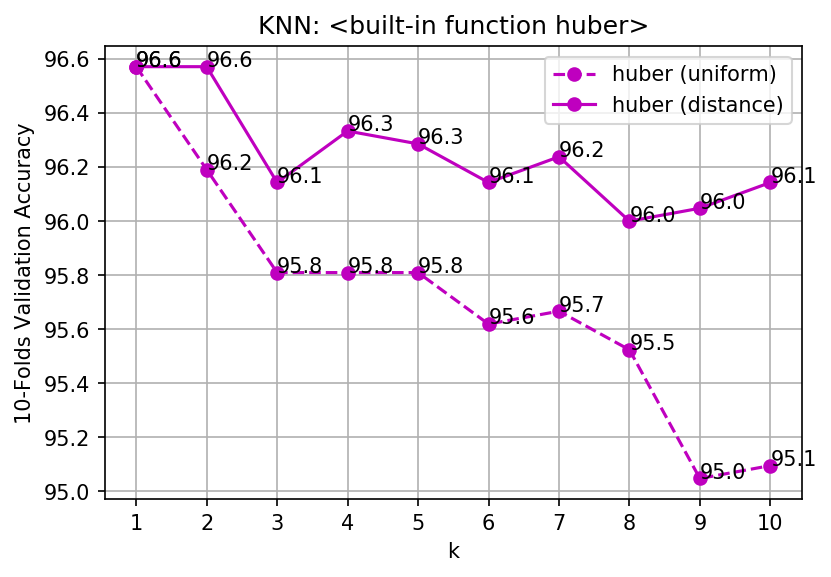

In [9]:
weights = ['uniform', 'distance']
metrics = ['l1', 'l2', 'chebyshev', l2_log]

plot_knn(['uniform'], metrics, 'KNN: Uniform')
plot_knn(['distance'], metrics, 'KNN: Distance')

for metric in metrics:
    plot_knn(['uniform', 'distance'], [metric], 'KNN: %s' % metric)



In [ ]:
plot_knn(['distance'], [l2_log], 'KNN: l2_log')
